<a href="https://colab.research.google.com/github/CSpanias/ml_training/blob/master/LogisticRegression(sonar_data).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Learning - Logistic Regression** 
*by [CSpanias](https://github.com/CSpanias), 12/12/2021*

This notebook was developed as a training script.

It is based on:
* [SONAR Rock vs Mine Prediction with Python](https://www.youtube.com/watch?v=fiz1ORTBGpY&list=PLfFghEzKVmjvuSA67LszN1dZ-Dd_pkus6)

The goal was to practice the logistic regression and improve the model developed in the above tutorial.

Things added:
1. [Multi-collinearity check](#MC)
2. [K-Fold Cross-Validation](#KFCV)
3. [Hyperparameter Optimization](#GS)
4. [Confusion Matrix](#CM)

In [167]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, accuracy_score, f1_score, make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, cross_validate, cross_val_score
from sklearn.model_selection import cross_val_predict, GridSearchCV

In [ ]:
# import dataset without headers
df = pd.read_csv("https://raw.githubusercontent.com/CSpanias/ml_training/master/sonar_data.csv", header=None)

<a name="DataPreProcessing"> </a>
# **Data PreProcessing**

In [ ]:
# print the first 5 rows of data
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,0.1609,0.1582,0.2238,0.0645,0.0660,0.2273,0.3100,0.2999,0.5078,0.4797,0.5783,0.5071,0.4328,0.5550,0.6711,0.6415,0.7104,0.8080,0.6791,0.3857,0.1307,0.2604,0.5121,0.7547,0.8537,0.8507,0.6692,0.6097,0.4943,0.2744,0.0510,0.2834,0.2825,0.4256,0.2641,0.1386,0.1051,0.1343,0.0383,0.0324,0.0232,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,0.4918,0.6552,0.6919,0.7797,0.7464,0.9444,1.0000,0.8874,0.8024,0.7818,0.5212,0.4052,0.3957,0.3914,0.3250,0.3200,0.3271,0.2767,0.4423,0.2028,0.3788,0.2947,0.1984,0.2341,0.1306,0.4182,0.3835,0.1057,0.1840,0.1970,0.1674,0.0583,0.1401,0.1628,0.0621,0.0203,0.0530,0.0742,0.0409,0.0061,0.0125,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,0.6333,0.7060,0.5544,0.5320,0.6479,0.6931,0.6759,0.7551,0.8929,0.8619,0.7974,0.6737,0.4293,0.3648,0.5331,0.2413,0.5070,0.8533,0.6036,0.8514,0.8512,0.5045,0.1862,0.2709,0.4232,0.3043,0.6116,0.6756,0.5375,0.4719,0.4647,0.2587,0.2129,0.2222,0.2111,0.0176,0.1348,0.0744,0.0130,0.0106,0.0033,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,0.0881,0.1992,0.0184,0.2261,0.1729,0.2131,0.0693,0.2281,0.4060,0.3973,0.2741,0.3690,0.5556,0.4846,0.3140,0.5334,0.5256,0.2520,0.2090,0.3559,0.6260,0.7340,0.6120,0.3497,0.3953,0.3012,0.5408,0.8814,0.9857,0.9167,0.6121,0.5006,0.3210,0.3202,0.4295,0.3654,0.2655,0.1576,0.0681,0.0294,0.0241,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,0.4152,0.3952,0.4256,0.4135,0.4528,0.5326,0.7306,0.6193,0.2032,0.4636,0.4148,0.4292,0.5730,0.5399,0.3161,0.2285,0.6995,1.0000,0.7262,0.4724,0.5103,0.5459,0.2881,0.0981,0.1951,0.4181,0.4604,0.3217,0.2828,0.2430,0.1979,0.2444,0.1847,0.0841,0.0692,0.0528,0.0357,0.0085,0.0230,0.0046,0.0156,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [ ]:
# check data types, size, and null-values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 61 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       208 non-null    float64
 1   1       208 non-null    float64
 2   2       208 non-null    float64
 3   3       208 non-null    float64
 4   4       208 non-null    float64
 5   5       208 non-null    float64
 6   6       208 non-null    float64
 7   7       208 non-null    float64
 8   8       208 non-null    float64
 9   9       208 non-null    float64
 10  10      208 non-null    float64
 11  11      208 non-null    float64
 12  12      208 non-null    float64
 13  13      208 non-null    float64
 14  14      208 non-null    float64
 15  15      208 non-null    float64
 16  16      208 non-null    float64
 17  17      208 non-null    float64
 18  18      208 non-null    float64
 19  19      208 non-null    float64
 20  20      208 non-null    float64
 21  21      208 non-null    float64
 22  22

In [ ]:
# number of rows and columns
df.shape

(208, 61)

In [ ]:
# get basic statistical data
df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000
mean,0.029164,0.038437,0.043832,0.053892,0.075202,0.104570,0.121747,0.134799,0.178003,0.208259,0.236013,0.250221,0.273305,0.296568,0.320201,0.378487,0.415983,0.452318,0.504812,0.563047,0.609060,0.624275,0.646975,0.672654,0.675424,0.699866,0.702155,0.694024,0.642074,0.580928,0.504475,0.439040,0.417220,0.403233,0.392571,0.384848,0.363807,0.339657,0.325800,0.311207,0.289252,0.278293,0.246542,0.214075,0.197232,0.160631,0.122453,0.091424,0.051929,0.020424,0.016069,0.013420,0.010709,0.010941,0.009290,0.008222,0.007820,0.007949,0.007941,0.006507
std,0.022991,0.032960,0.038428,0.046528,0.055552,0.059105,0.061788,0.085152,0.118387,0.134416,0.132705,0.140072,0.140962,0.164474,0.205427,0.232650,0.263677,0.261529,0.257988,0.262653,0.257818,0.255883,0.250175,0.239116,0.244926,0.237228,0.245657,0.237189,0.240250,0.220749,0.213992,0.213237,0.206513,0.231242,0.259132,0.264121,0.239912,0.212973,0.199075,0.178662,0.171111,0.168728,0.138993,0.133291,0.151628,0.133938,0.086953,0.062417,0.035954,0.013665,0.012008,0.009634,0.007060,0.007301,0.007088,0.005736,0.005785,0.006470,0.006181,0.005031
min,0.001500,0.000600,0.001500,0.005800,0.006700,0.010200,0.003300,0.005500,0.007500,0.011300,0.028900,0.023600,0.018400,0.027300,0.003100,0.016200,0.034900,0.037500,0.049400,0.065600,0.051200,0.021900,0.056300,0.023900,0.024000,0.092100,0.048100,0.028400,0.014400,0.061300,0.048200,0.040400,0.047700,0.021200,0.022300,0.008000,0.035100,0.038300,0.037100,0.011700,0.036000,0.005600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000800,0.000500,0.001000,0.000600,0.000400,0.000300,0.000300,0.000100,0.000600
25%,0.013350,0.016450,0.018950,0.024375,0.038050,0.067025,0.080900,0.080425,0.097025,0.111275,0.129250,0.133475,0.166125,0.175175,0.164625,0.196300,0.205850,0.242075,0.299075,0.350625,0.399725,0.406925,0.450225,0.540725,0.525800,0.544175,0.531900,0.534775,0.463700,0.411400,0.345550,0.281400,0.257875,0.217575,0.179375,0.154350,0.160100,0.174275,0.173975,0.186450,0.163100,0.158900,0.155200,0.126875,0.094475,0.068550,0.064250,0.045125,0.026350,0.011550,0.008425,0.007275,0.005075,0.005375,0.004150,0.004400,0.003700,0.003600,0.003675,0.003100
50%,0.022800,0.030800,0.034300,0.044050,0.062500,0.092150,0.106950,0.112100,0.152250,0.182400,0.224800,0.249050,0.263950,0.281100,0.281700,0.304700,0.308400,0.368300,0.434950,0.542500,0.617700,0.664900,0.699700,0.698500,0.721100,0.754500,0.745600,0.731900,0.680800,0.607150,0.490350,0.429600,0.391200,0.351050,0.312750,0.321150,0.306300,0.312700,0.283500,0.278050,0.259500,0.245100,0.222550,0.177700,0.148000,0.121350,0.101650,0.078100,0.044700,0.017900,0.013900,0.011400,0.009550,0.009300,0.007500,0.006850,0.005950,0.005800,0.006400,0.005300
75%,0.035550,0.047950,0.057950,0.064500,0.100275,0.134125,0.154000,0.169600,0.233425,0.268700,0.301650,0.331250,0.351250,0.386175,0.452925,0.535725,0.659425,0.679050,0.731400,0.809325,0.816975,0.831975,0.848575,0.872175,0.873725,0.893800,0.917100,0.900275,0.852125,0.735175,0.641950,0.580300,0.556125,0.596125,0.593350,0.556525,0.518900,0.440550,0.434900,0.424350,0.387525,0.384250,0.324525,0.271750,0.231550,0.200375,0.154425,0.120100,0.0685

In [ ]:
# check for missing data
df.isnull().sum()

0     0
1     0
2     0
3     0
4     0
     ..
56    0
57    0
58    0
59    0
60    0
Length: 61, dtype: int64

In [ ]:
# check target labels (M = mine, R = rock)
df[60].value_counts()

M    111
R     97
Name: 60, dtype: int64

<a name="MC"> </a>
Check for highly-correlated values:

In [ ]:
# check for multi-collinearity
df.corr()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
0,1.000000,0.735896,0.571537,0.491438,0.344797,0.238921,0.260815,0.355523,0.353420,0.318276,0.344058,0.210861,0.210722,0.256278,0.304878,0.239079,0.137845,0.041817,0.055227,0.156760,0.117663,-0.056973,-0.163426,-0.218093,-0.295683,-0.342865,-0.341703,-0.224340,-0.199099,-0.077430,-0.048370,-0.030444,-0.031939,0.031319,0.098118,0.080722,0.119565,0.209873,0.208371,0.099993,0.127313,0.213592,0.206057,0.157949,0.279968,0.319354,0.230343,0.203234,0.247560,0.269287,0.254450,0.355299,0.311729,0.322299,0.312067,0.220642,0.313725,0.368132,0.357116,0.347078
1,0.735896,1.000000,0.779916,0.606684,0.419669,0.332329,0.279040,0.334615,0.316733,0.270782,0.297065,0.194102,0.249596,0.273170,0.307599,0.261844,0.152170,0.042870,0.040911,0.102428,0.075255,-0.074157,-0.179365,-0.196469,-0.295302,-0.365749,-0.337046,-0.234386,-0.228490,-0.115301,-0.055862,-0.049683,-0.108272,-0.004247,0.115824,0.132611,0.169186,0.217494,0.186828,0.098350,0.188226,0.261345,0.186368,0.133018,0.285716,0.304247,0.255797,0.265279,0.313995,0.245868,0.320538,0.434548,0.346076,0.383960,0.380165,0.262263,0.280341,0.353042,0.352200,0.358761
2,0.571537,0.779916,1.000000,0.781786,0.546141,0.346275,0.190434,0.237884,0.252691,0.219637,0.274610,0.214807,0.258767,0.291724,0.285663,0.237017,0.201093,0.120587,0.099303,0.103117,0.063990,-0.026815,-0.073400,-0.085380,-0.214256,-0.291974,-0.263111,-0.256674,-0.290728,-0.197493,-0.106198,-0.109895,-0.170671,-0.099409,0.017053,0.053070,0.107530,0.130276,0.110499,0.074137,0.189047,0.233442,0.113920,0.071946,0.180734,0.173649,0.179528,0.234896,0.223074,0.081096,0.238110,0.394076,0.332914,0.367186,0.289731,0.287661,0.380819,0.334108,0.425047,0.373948
3,0.491438,0.606684,0.781786,1.000000,0.726943,0.352805,0.246440,0.246742,0.247078,0.237769,0.271881,0.175381,0.215754,0.286708,0.278529,0.248245,0.223203,0.194992,0.189405,0.188317,0.142271,0.036010,-0.029749,-0.102975,-0.206673,-0.291357,-0.294749,-0.256074,-0.300476,-0.236602,-0.190086,-0.169987,-0.164651,-0.083965,0.015200,0.039282,0.063486,0.089887,0.089346,0.045141,0.145241,0.144693,0.050629,-0.008407,0.087824,0.080012,0.046109,0.121065,0.133294,0.077925,0.174676,0.374651,0.364772,0.334211,0.284955,0.280938,0.340254,0.344865,0.420266,0.400626
4,0.344797,0.419669,0.546141,0.726943,1.000000,0.597053,0.335422,0.204006,0.177906,0.183219,0.231684,0.211657,0.299086,0.359062,0.318059,0.328725,0.326477,0.299266,0.340543,0.285737,0.205088,0.152897,0.073934,-0.000624,-0.067296,-0.125675,-0.169618,-0.214692,-0.283863,-0.273350,-0.214336,-0.173485,-0.200586,-0.140559,-0.086529,-0.073481,-0.064617,-0.008620,0.063408,0.061616,0.098832,0.125181,0.063706,0.031575,0.089202,0.081964,0.041419,0.084435,0.088128,0.066751,0.115936,0.266617,0.314985,0.205306,0.196472,0.199323,0.219395,0.238793,0.290982,0.253710
5,0.238921,0.332329,0.346275,0.352805,0.597053,1.000000,0.702889,0.471683,0.327578,0.288621,0.333570,0.344451,0.411107,0.396233,0.367908,0.353783,0.293190,0.235778,0.226305,0.206841,0.174768,0.123770,0.064081,0.027026,-0.043280,-0.100309,-0.129094,-0.118645,-0.156081,-0.151186,-0.054136,-0.051934,-0.144391,-0.070337,-0.028815,-0.023621,-0.064798,-0.048745,0.030599,0.081119,0.075797,0.048763,0.034380,0.048870,0.085468,0.029524,0.016640,0.067196,0.080729,0.017300,0.171767,0.252288,0.162404,0.164073,0.133464,0.166758,0.161333,0.203986,0.220573,0.178158
6,0.260815,0.279040,0.190434,0.246440,0.335422,0.702889,1.000000,0.675774,0.470580,0.425448,0.396588,0.274432,0.365391,0.409576,0.411692,0.363086,0.250024,0.208057,0.215495,0.196496,0.165827,0.063773,0.009359,0.011982,-0.057147,-0.126074,-0.179526,-0.116848,-0.129694,-0.068142,-0.096945,-0.115871,-0.127052,-0.077662,-0.015531,0.002979,-0.001376,0.065900,0.080942,0.112673,0.041071,-0.028720,-0.025727,0.061404,0.110813,0.076537,0.098925,0.155221,0.194720,0.166112,0.184152,0.144051,0.046403,0.16

In [147]:
# remove high correlated values
df.drop(columns=[9, 14, 15], axis=1, inplace=True)
# check shape
df.shape

(208, 58)

In [151]:
# mean value per label
df.groupby(60).mean()

,0,1,2,3,4,5,6,7,8,10,11,12,13,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
60,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
M,0.034989,0.045544,0.050720,0.064768,0.086715,0.111864,0.128359,0.149832,0.213492,0.289581,0.301459,0.314426,0.320692,0.415007,0.455882,0.538062,0.617941,0.667426,0.672325,0.676701,0.689165,0.681204,0.706075,0.714754,0.712269,0.650283,0.581796,0.482378,0.428049,0.396577,0.36614,0.337553,0.318553,0.317034,0.331608,0.336365,0.305221,0.292594,0.300975,0.276883,0.248106,0.245225,0.198804,0.146917,0.110594,0.063708,0.022721,0.019352,0.016014,0.011643,0.012185,0.009923,0.008914,0.007825,0.009060,0.008695,0.006930
R,0.022498,0.030303,0.035951,0.041447,0.062028,0.096224,0.114180,0.117596,0.137392,0.174713,0.191589,0.226249,0.268963,0.417100,0.448240,0.466762,0.500229,0.542270,0.569290,0.612959,0.653761,0.668809,0.692762,0.687737,0.673145,0.632680,0.579934,0.529762,0.451619,0.440841,0.44568,0.455530,0.460710,0.417330,0.348868,0.313709,0.318057,0.285428,0.252338,0.211822,0.175132,0.142312,0.116949,0.094458,0.069488,0.038449,0.017796,0.012311,0.010453,0.009640,0.009518,0.008567,0.007430,0.007814,0.006677,0.007078,0.006024


In [152]:
# seperating data and lables
X = df.drop(columns=60, axis=1)
y = df[60]

In [153]:
# check that the shape looks OK
print(X.shape)
print(y.shape)

(208, 57)
(208,)


<a name="KFCV"> </a>
# **Model Training & Evalution Process**
* Replaced train_test_split with cross_validation for a more objective accuracy estimate

In [155]:
# split training and test data using cross-validation
kf = KFold(n_splits=10, shuffle=True)

In [156]:
# select algorithm
model = LogisticRegression()

<a name="GS"> </a>
# **Hyperparameter Optimization**

In [157]:
# declare parameters for hyperparameter tuning
params = [
          {
          'C': [0.1, 1, 10],
          'fit_intercept':['True', 'False'],
          'solver': ['liblinear'],
           'max_iter': [10, 100, 200, 500, 1000],
           'multi_class': ['auto', 'ovr'],
           },
          ]

# create the grid search object
gs = GridSearchCV(model, params, scoring='accuracy', cv=kf,
                  return_train_score=True, verbose=3)

# fit the gs object
gs.fit(X, y)

Fitting 10 folds for each of 60 candidates, totalling 600 fits
[CV 1/10] END C=0.1, fit_intercept=True, max_iter=10, multi_class=auto, solver=liblinear;, score=(train=0.733, test=0.714) total time=   0.0s
[CV 2/10] END C=0.1, fit_intercept=True, max_iter=10, multi_class=auto, solver=liblinear;, score=(train=0.754, test=0.810) total time=   0.0s
[CV 3/10] END C=0.1, fit_intercept=True, max_iter=10, multi_class=auto, solver=liblinear;, score=(train=0.727, test=0.714) total time=   0.0s
[CV 4/10] END C=0.1, fit_intercept=True, max_iter=10, multi_class=auto, solver=liblinear;, score=(train=0.711, test=0.571) total time=   0.0s
[CV 5/10] END C=0.1, fit_intercept=True, max_iter=10, multi_class=auto, solver=liblinear;, score=(train=0.711, test=0.667) total time=   0.0s
[CV 6/10] END C=0.1, fit_intercept=True, max_iter=10, multi_class=auto, solver=liblinear;, score=(train=0.738, test=0.667) total time=   0.0s
[CV 7/10] END C=0.1, fit_intercept=True, max_iter=10, multi_class=auto, solver=liblin

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             estimator=LogisticRegression(),
             param_grid=[{'C': [0.1, 1, 10], 'fit_intercept': ['True', 'False'],
                          'max_iter': [10, 100, 200, 500, 1000],
                          'multi_class': ['auto', 'ovr'],
                          'solver': ['liblinear']}],
             return_train_score=True, scoring='accuracy', verbose=3)

In [158]:
# print estimator that was chosen by the GridSearch
print('\nEstimator that was chosen by the search:', gs.best_estimator_)

# mean cross-validated score of the best_estimator
print('\nMean cross-validated score of the best_estimator:', round(gs.best_score_, 4))

# Scorer function used on the held out data to choose the best parameters for the model
print('\nMean cross-validate score of GS:', round(gs.score(X, y), 4))


Estimator that was chosen by the search: LogisticRegression(C=10, fit_intercept='True', max_iter=10, solver='liblinear')

Mean cross-validated score of the best_estimator: 0.7879

Mean cross-validate score of GS: 0.8702


In [159]:
# select algorithm's parameters
model = LogisticRegression(C=10, fit_intercept='True', max_iter=10, solver='liblinear')
# select desired metrics
scoring = ['accuracy']
# calculate accuracy score
cv_scores = cross_validate(model, X, y, cv=kf,scoring=scoring,
                           return_train_score=True)

Check for **overfitting** issues via training and testing scores.

In [160]:
train_splits = []
test_splits = []
for key, value in cv_scores.items():
  if key == 'train_accuracy':
    train_splits.append(value)
  if key == 'test_accuracy':
    test_splits.append(value)

# set column names
split_cols_names = ['split 1', 'split 2', 'split 3', 'split 4', 'split 5',
                    'split 6', 'split 7', 'split 8', 'split 9', 'split 10']

# convert lists of scores to dataframe
train_scores = pd.DataFrame(train_splits, columns=split_cols_names)
test_scores = pd.DataFrame(test_splits, columns=split_cols_names)

# rename rows
train_scores.rename(index = {0: "Accuracy (Train)"}, inplace = True)
test_scores.rename(index = {0: "Accuracy (Test)"}, inplace = True)

# merge both dataframes into a single one
data = train_scores.append(test_scores)

# calculate mean scores
mean_scores = data.mean(axis=1)

# append column to the dataframe
data['mean'] = round(mean_scores, 4)
# display dataframe as a tables
display(data)

,split 1,split 2,split 3,split 4,split 5,split 6,split 7,split 8,split 9,split 10,mean
Accuracy (Train),0.855615,0.871658,0.882353,0.887701,0.866310,0.877005,0.860963,0.855615,0.87766,0.87234,0.8707
Accuracy (Test),0.714286,0.761905,0.666667,0.761905,0.904762,0.714286,0.761905,0.857143,0.80000,0.90000,0.7843


<a name="CM"> </a>
Generate a **Confusion Matrix**:

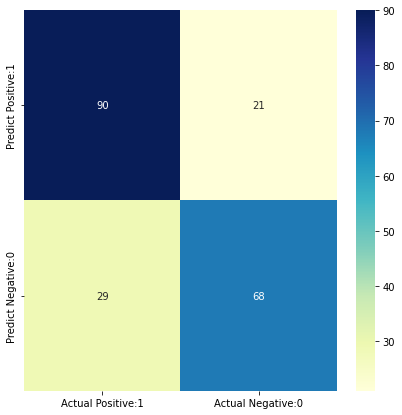

In [168]:
# predict using cross validation
y_pred = cross_val_predict(model, X, y, cv=kf)
# generate the confusion matrix
cm = confusion_matrix(y, y_pred)
# visualize confusion matrix with seaborn heatmap
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1',
                                           'Actual Negative:0'],
                        index=['Predict Positive:1', 'Predict Negative:0'])
fig, ax = plt.subplots(figsize=(7,7))  
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')